# Sea Ice Concentration

This a first pass of the information we might be interested in for the MIZ 2023 voyage and resulting research from a sea ice concentration dataset.

This example is using the NSIDC Sea Ice Concentration gridded data set

In [1]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

In [24]:
import sys
sys.path.append('/g/data/jk72/as2285/miz/')

from utils.sea_ice_conc import sea_ice_conc_monthly

In [2]:
#some constants used here (maybe we should centralise?)
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
CONC_RANGE=[0.15,1] #range of valid concentrations

A class to capture the data and processing functions

In [4]:
def plot_climat(ds):
    plt.plot(
        ds.month,
        ds.ave, 
        color='black',
        label='Mean'
    )

    plt.fill_between(
        ds.month,
        ds.ave-2*ds.stDev, 
        ds.ave+2*ds.stDev,
        color='lightgrey',
        label='95% CI'
    )

    plt.xticks(
        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
        labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    )

    plt.ylabel('km\u00b2')
    plt.legend()
    
def plot_year(da, year):
    plt.plot(
        [1,2,3,4,5,6,7,8,9,10,11,12],
        da.where(da.time.dt.year==int(year), drop=True),
        color='red',
        linestyle='dashed',
        label=str(int(year))
    )
    
    plt.legend()


# Open the dataset

In this case, looking at the monthly averages of sea ice concentration

In [5]:
cdrXr = xr.open_dataset(
    '/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/NOAA/G02202_V4/south/aggregate/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
)

cdrXr = cdrXr.swap_dims({'tdim':'time'})

In [6]:
cdrXr

<xarray.Dataset>
Dimensions:                           (time: 518, y: 332, x: 316)
Coordinates:
  * time                              (time) datetime64[ns] 1978-11-01 ... 20...
    xgrid                             (x) float32 ...
    ygrid                             (y) float32 ...
Dimensions without coordinates: y, x
Data variables:
    cdr_seaice_conc_monthly           (time, y, x) float32 ...
    nsidc_bt_seaice_conc_monthly      (time, y, x) float32 ...
    nsidc_nt_seaice_conc_monthly      (time, y, x) float32 ...
    projection                        |S1 ...
    qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 ...
    stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 ...
    latitude                          (y, x) float32 ...
    longitude                         (y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T15:54:57Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         2021-12-31T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

Annoyingly, the area of each grid cell is provided seperately

In [7]:
datFile=open('/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. 

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area? <b>(Confirm this?)</b>

In [8]:
ant_conc=seaice_conc_monthly(
    cdrXr.cdr_seaice_conc_monthly, 
    areasKmNd
)

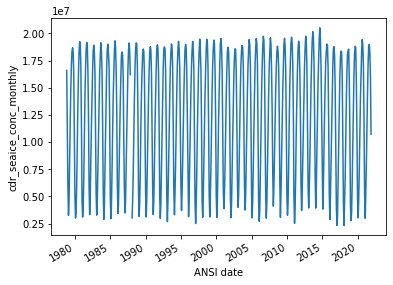

In [9]:
ant_conc.calc_extent()
ant_conc.extent_da.plot();

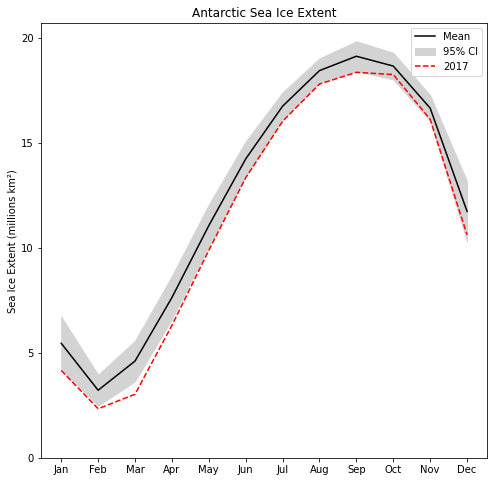

In [10]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, 2017)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')
plt.legend()
plt.show()

# 

In [11]:
ant_conc.calc_area()


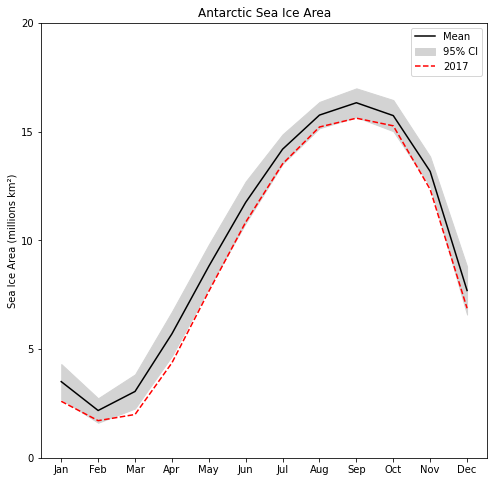

In [12]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(ant_conc.area_climat_ds)

plot_year(ant_conc.area_da, 2017)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.title('Antarctic Sea Ice Area')
plt.show()

# distribution of sea ice

Monthly mean concentrations (1981-2010)

In [13]:
ant_conc.calc_gridded_anoms()

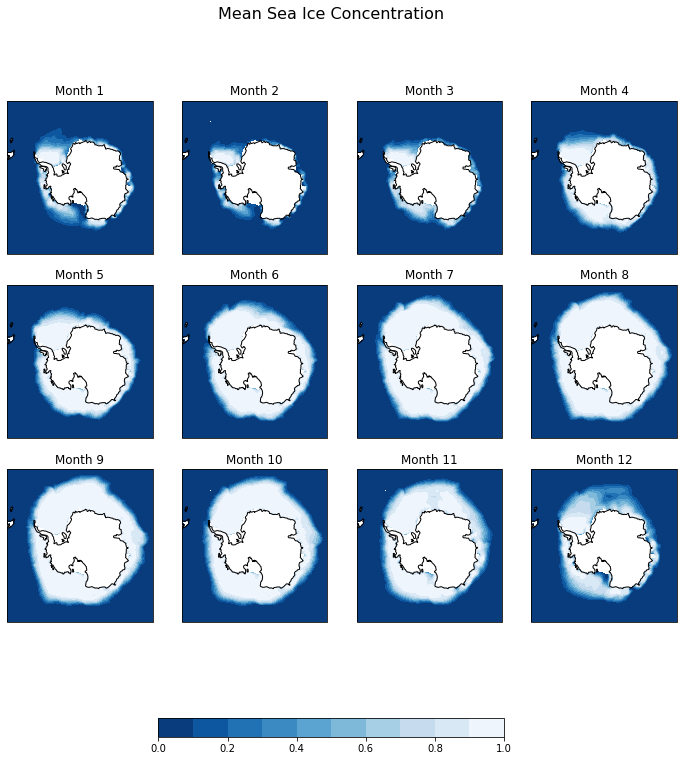

In [14]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# anomalies in distribution of sea ice

In [15]:
year="2017"

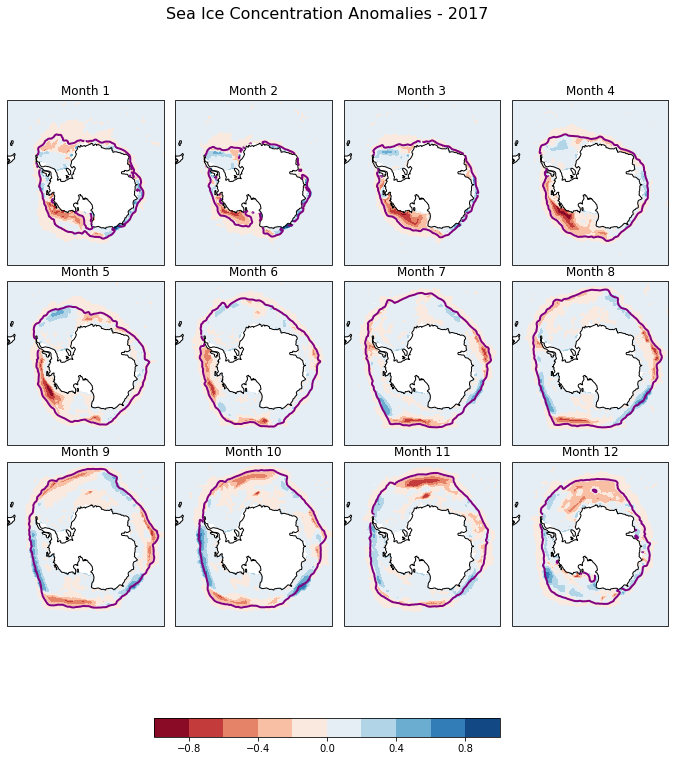

In [16]:
plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - 2017', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=ant_conc.anoms_da.sel(time=np.datetime64(year+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title('Month ' + str(iMonth))

plt.subplots_adjust(hspace=0.1,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# Repeat for east Antarctic only

In [17]:
EAST_ANT_LONS

[71, 160]

In [18]:
e_ant_conc=seaice_conc_monthly(
    cdrXr.where(
        (cdrXr.longitude>EAST_ANT_LONS[0])
        *(cdrXr.longitude<EAST_ANT_LONS[1])
    ).cdr_seaice_conc_monthly, 
    areasKmNd
)

In [19]:
e_ant_conc.calc_extent()

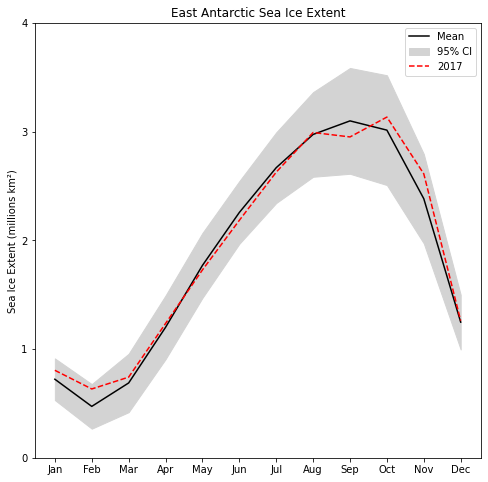

In [20]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(e_ant_conc.extent_climat_ds)

plot_year(e_ant_conc.extent_da, 2017)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.show()

In [21]:
e_ant_conc.calc_area()

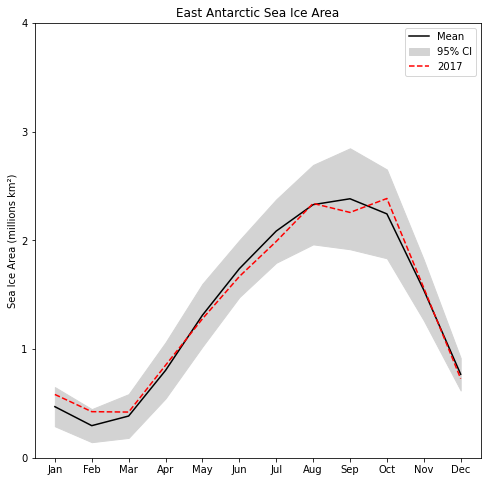

In [22]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(e_ant_conc.area_climat_ds)

plot_year(e_ant_conc.area_da, 2017)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.show()

In [23]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
# (https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/Making_Maps_with_Cartopy.ipynb)

import matplotlib.path as mpath

def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

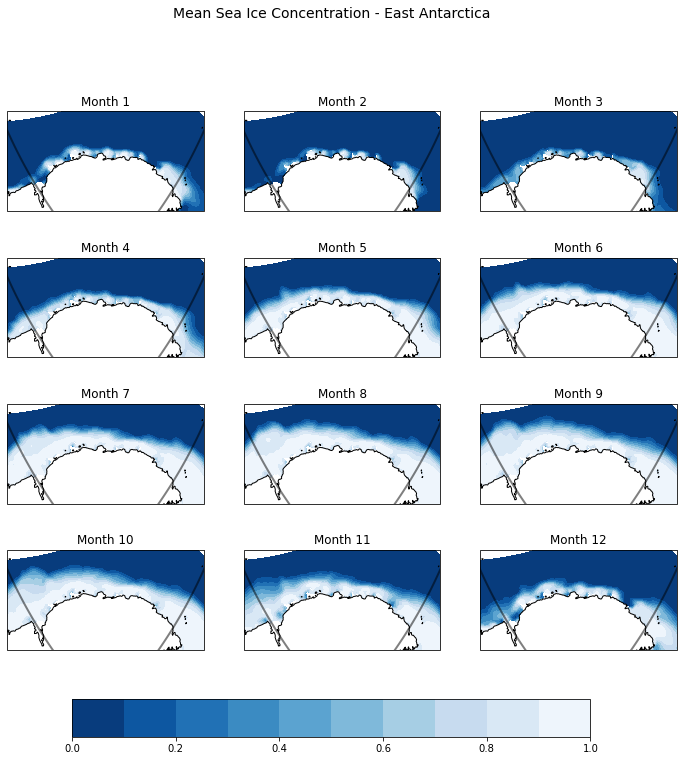

In [24]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration - East Antarctica', fontsize=14)


for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(
        5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

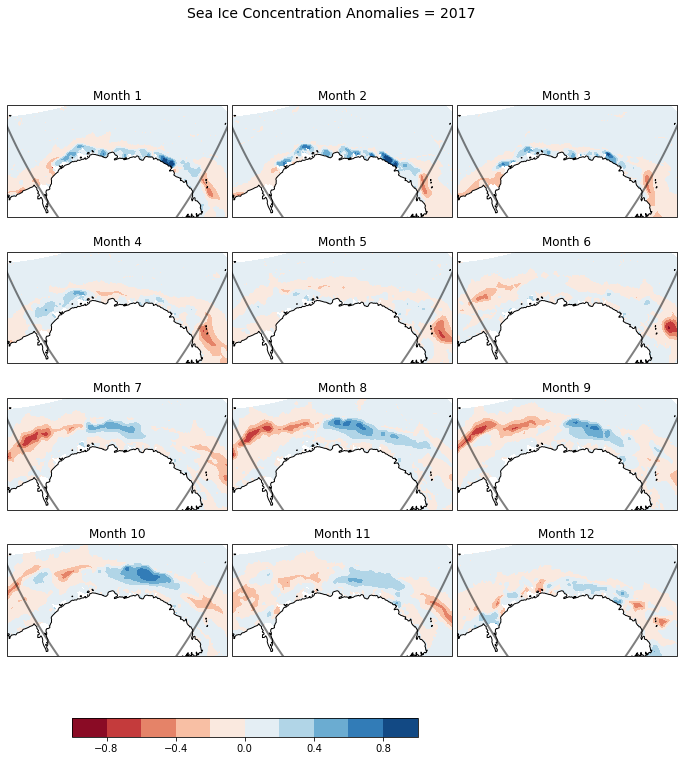

In [25]:
plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies = 2017', fontsize = 14)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        #toPlot.xgrid, 
        #toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=ant_conc.anoms_da.sel(time=np.datetime64(year+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

Whats missing:

- near-real time data

- validation

Some other plots could be:

- changes to max or min extent/area over time

- length of advance/duration/retreat ( do the sector - number of days)